In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from CASutils import regrid_utils as regrid
from CASutils import mapplot_utils as mymaps
from CASutils import colorbar_utils as cbars
from CASutils import averaging_utils as avg
from CASutils import linfit_utils as linfit

from math import nan
from functools import partial

import cartopy.crs as ccrs
import warnings
import sys
warnings.filterwarnings("ignore")

In [2]:
plotpath="/project/cas/islas/python_plots/singleforcing_paper/figures/"

### Read in piControl data for FSUS regressed onto AMOC

In [3]:
pi_amoc = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/piControl/CESM2/piControl_AMOC_am.nc").MOC
pi_albedo = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/piControl/CESM2/piControl_albedo_am.nc").Albedo
pi_fsus = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/piControl/CESM2/piControl_fsus_integral_am.nc").FSUS

pi_amoc = pi_amoc.sel(year=slice(400,2000))
pi_albedo = pi_albedo.sel(year=slice(400,2000))
pi_fsus = pi_fsus.sel(year=slice(400,2000))

### Detrend because there's some drift in FSUS

In [4]:
a, b = linfit.linfit_xy(pi_fsus.year, pi_fsus)
pi_fsus = pi_fsus - (a + b*pi_fsus.year)

a, b = linfit.linfit_xy(pi_amoc.year, pi_amoc)
pi_amoc = pi_amoc - (a + b*pi_amoc.year)

### Read in experiments AMOC's

In [5]:
aaer2_amoc = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2-SF/AAER_AMOC45_am.nc")
lens2_amoc = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2/LENS2_AMOC45_am.nc")
xaer2_amoc = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM2-XAAER/xAER_AMOC45_am.nc")

aaer2_amoc = aaer2_amoc.mean('M')
lens2_amoc = lens2_amoc.mean('M')
xaer2_amoc = xaer2_amoc.mean('M')

aaer2_base = aaer2_amoc.sel(year=slice(1920,1940)).mean('year')
lens2_base = lens2_amoc.sel(year=slice(1920,1940)).mean('year')
xaer2_base = xaer2_amoc.sel(year=slice(1920,1940)).mean('year')

aaer2_amoc = aaer2_amoc - aaer2_base
lens2_amoc = lens2_amoc - lens2_base
xaer2_amoc = xaer2_amoc - xaer2_base

aaer2xway = lens2_amoc - xaer2_amoc

amocdif = aaer2_amoc - aaer2xway

### Calculate 21 year running means

In [6]:
pi_amoc_sm = pi_amoc.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
pi_albedo_sm = pi_albedo.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
pi_fsus_sm = pi_fsus.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
amocdifsm = amocdif.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')

### Lagged regression of FSUS onto AMOC

In [7]:
lag = np.arange(-40,41)

regfsus = np.zeros(len(lag))

for ilag in np.arange(0,len(lag),1):
    
    amocshift = pi_amoc_sm.shift(year=lag[ilag]).dropna(dim='year')
    minyear = amocshift.year[0] ; maxyear = amocshift.year[len(amocshift)-1]
    
    fsususe = pi_fsus_sm[ (pi_fsus_sm.year >= minyear) & (pi_fsus_sm.year <= maxyear) ]
    a, b = linfit.linfit_xy(amocshift, fsususe)
    regfsus[ilag] = b

### Testing the lagged regression by hand as I wasn't sure I was interpreting "shift" right.

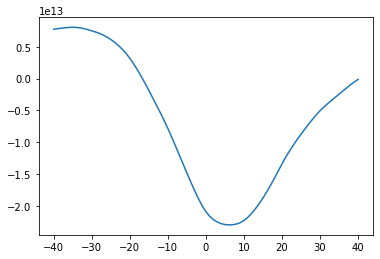

In [8]:
lag = np.arange(-40,41)

regtest = np.zeros(len(lag))

for ilag in np.arange(0,len(lag),1):
    amocuse = pi_amoc_sm.isel(year=slice(40,pi_amoc_sm.year.size-40))
    fsususe = pi_fsus_sm.isel(year=slice(40+lag[ilag], pi_amoc_sm.year.size-40+lag[ilag]))
    
    a, b = linfit.linfit_xy(amocuse, fsususe)
    regtest[ilag] = b
    
plt.plot(lag, regtest)

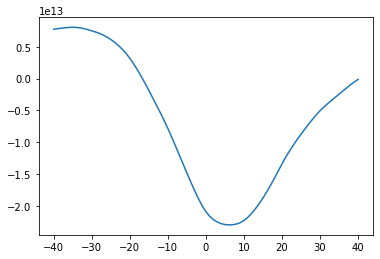

In [9]:
plt.plot(lag, regtest)

### Construct the FSUS change based on AMOC

In [10]:
imin = np.argmin(regfsus) ; minval = np.min(regfsus)
fsus_construct = np.zeros(amocdifsm.year.size)
fsus_construct[:] = nan

for itime in np.arange(lag[imin], amocdifsm.year.size,1):
    fsus_construct[itime] = minval * amocdifsm.MOC[itime-lag[imin]]

In [11]:
print(minval)

-22581825621456.266


### Read in the actual difference in globally integrated FSUS

In [12]:
seas = 'am' ; var = ['FSNS','FSDS']

landfrac = xr.open_dataset("/project/cas/islas/cesm2le/fx/LANDFRAC_LENS2.nc")

def preprocessor(ds):
    ds['lon'] = landfrac.lon ; ds['lat'] = landfrac.lat
    ds = ds.mean('M')
    ds = ds.sel(year=slice(1920,2050))
    return ds

baselens2='/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2/'
lens2 = []
for ivar in var:
    dat = xr.open_mfdataset(baselens2+'LENS2_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    lens2.append(dat)
lens2 = xr.merge(lens2)
fsus = lens2.FSDS - lens2.FSNS
fsus = fsus.rename('FSUS')
lens2 = xr.merge([lens2, fsus])

basexaer2="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM2-XAAER/"
xaer2 = []
for ivar in var:
    dat = xr.open_mfdataset(basexaer2+'xAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    xaer2.append(dat)
xaer2 = xr.merge(xaer2)
fsus = xaer2.FSDS - xaer2.FSNS
fsus = fsus.rename('FSUS')
xaer2 = xr.merge([xaer2, fsus])

baseaer2="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2-SF/"
aer2 = []
for ivar in var:
    dat = xr.open_mfdataset(baseaer2+'AAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    aer2.append(dat)
aer2 = xr.merge(aer2)
fsus = aer2.FSDS - aer2.FSNS
fsus = fsus.rename('FSUS')
aer2 = xr.merge([aer2, fsus])

In [13]:
def calcglobalsum(darray, lon1, lon2, lat1, lat2):
    a = 6.37e6
    latrad = np.deg2rad(darray.lat)
    dphi = xr.DataArray(np.zeros([latrad.size]), coords=[darray.lat], dims=['lat'], name='dphi')
    dphimid = [ ((latrad.isel(lat=i+1).values - latrad.isel(lat=i).values)/2. + 
                (latrad.isel(lat=i).values - latrad.isel(lat=i-1).values)/2.) for i in np.arange(1,latrad.size-1,1) ]
    dphi[1:darray.lat.size-1] = dphimid
    dphi[0] = (latrad.isel(lat=1).values - latrad.isel(lat=0).values)/2. + (latrad.isel(lat=0).values - np.deg2rad(-90))
    dphi[darray.lat.size-1] = (latrad.isel(lat=latrad.size-1).values - latrad.isel(lat=latrad.size-2).values)/2. + \
                               np.deg2rad(90) - latrad.isel(lat=latrad.size-1).values
    lonrad = np.deg2rad(darray.lon)
    dlon = lonrad[1].values - lonrad[0].values

    cosphi = xr.DataArray(np.zeros([latrad.size]), coords=[darray.lat], dims=['lat'], name='cosphi')
    cosphi[:] = np.cos(np.deg2rad(darray.lat.values))
    
    weights = xr.DataArray(np.ones([latrad.size, lonrad.size]), coords=[darray.lat, darray.lon], dims=['lat','lon'], name='weights')
    weights = a**2 * weights*cosphi*dphi*dlon
    
    region = darray.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
    weights = weights.sel(lon=slice(lon1, lon2), lat=slice(lat1,lat2))
    
    regionw = region.weighted(weights)
    integral = regionw.sum(("lon","lat"))
    
    return integral

In [14]:
lens2_int = calcglobalsum(lens2,0,360,-90,90)
aer2_int = calcglobalsum(aer2, 0, 360, -90, 90)
xaer2_int = calcglobalsum(xaer2, 0, 360, -90, 90)

lens2_int_nh = calcglobalsum(lens2,0,360,0,90)
aer2_int_nh = calcglobalsum(aer2, 0, 360, 0, 90)
xaer2_int_nh = calcglobalsum(xaer2, 0, 360, 0, 90)

In [15]:
lens2_intbase = lens2_int.sel(year=slice(1920,1940)).mean('year')
aer2_intbase = aer2_int.sel(year=slice(1920,1940)).mean('year')
xaer2_intbase = xaer2_int.sel(year=slice(1920,1940)).mean('year')

lens2_intbase_nh = lens2_int_nh.sel(year=slice(1920,1940)).mean('year')
aer2_intbase_nh = aer2_int_nh.sel(year=slice(1920,1940)).mean('year')
xaer2_intbase_nh = xaer2_int_nh.sel(year=slice(1920,1940)).mean('year')

In [16]:
lens2anoms_int = lens2_int - lens2_intbase
aer2anoms_int = aer2_int - aer2_intbase
xaer2anoms_int = xaer2_int - xaer2_intbase

lens2anoms_int_nh = lens2_int_nh - lens2_intbase_nh
aer2anoms_int_nh = aer2_int_nh - aer2_intbase_nh
xaer2anoms_int_nh = xaer2_int_nh - xaer2_intbase_nh

In [17]:
aer2xwayanoms_int = lens2anoms_int - xaer2anoms_int
aer2xwayanoms_int_nh = lens2anoms_int_nh - xaer2anoms_int_nh

### Calculate 21 year running means

In [18]:
# 21 year running means
def calc21ymean(dat):
    datm = dat.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
    return datm

In [19]:
aer2anoms_int_21y = calc21ymean(aer2anoms_int)
aer2xwayanoms_int_21y = calc21ymean(aer2xwayanoms_int)

aer2anoms_int_nh_21y = calc21ymean(aer2anoms_int_nh)
aer2xwayanoms_int_nh_21y = calc21ymean(aer2xwayanoms_int_nh)

In [20]:
aer2anoms_int_21y = aer2anoms_int_21y.load() ; aer2xwayanoms_int_21y = aer2xwayanoms_int_21y.load()
aer2anoms_int_nh_21y = aer2anoms_int_nh_21y.load() ; aer2xwayanoms_int_nh_21y = aer2xwayanoms_int_nh_21y.load()

### Plot the plot

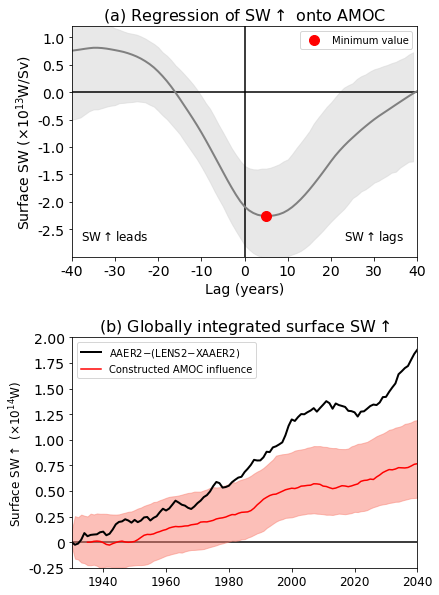

In [22]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.75,0.3,0.2])
ax.set_xlim(-40,40)
ax.set_ylim(-3e13, 1.2e13)
ax.set_yticks([-2.5e13,-2e13,-1.5e13,-1e13,-0.5e13,0,0.5e13,1e13])
ax.set_yticklabels(['-2.5','-2.0','-1.5','-1.0','-0.5','0.0','0.5','1.0'], fontsize=14)
ax.set_ylabel('Surface SW ($\\times$10$^{13}$W/Sv)', fontsize=14)
ax.set_xticks([-40,-30,-20,-10,0,10,20,30,40])
ax.set_xticklabels(['-40','-30','-20','-10','0','10','20','30','40'], fontsize=14)
ax.set_xlabel('Lag (years)', fontsize=14)
ax.set_title('(a) Regression of SW$\\uparrow$ onto AMOC', fontsize=16)

ax.plot([-40,40],[0,0], color='black')
ax.plot([0,0],[-3e13, 1.2e13], color='black')

boot = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/fig10/CESM2_FSUSregontoMOC.nc")
ax.fill_between(boot.lag, boot.min95_fsusreg, boot.max95_fsusreg, color='lightgray', alpha=0.5)

ax.plot(lag, regfsus, color='gray', linewidth=2)
ax.plot(lag[imin], minval, "o", markerfacecolor='red', markeredgecolor='red', markersize=10, label='Minimum value')
ax.legend()

ax.text(-30,-2.7e13,'SW$\\uparrow$leads', fontsize=12, ha='center')
ax.text(30,-2.7e13, 'SW$\\uparrow$lags', fontsize=12, ha='center')


ax = fig.add_axes([0.05,0.48,0.3,0.2])
ax.set_ylim(-0.25e14,2e14)
ax.set_yticks([-0.25e14,0,0.25e14, 0.5e14, 0.75e14, 1e14, 1.25e14, 1.5e14, 1.75e14, 2e14])
ax.set_yticklabels(['-0.25','0','0.25','0.50','0.75','1.00','1.25','1.50','1.75','2.00'], fontsize=14)
ax.set_ylabel('Surface SW$\\uparrow$ ($\\times$10$^{14}$W)', fontsize=12)
ax.set_xlim(1930,2040)
ax.set_xticks([1940,1960,1980,2000,2020,2040])
ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=12)
ax.plot(aer2anoms_int_21y.year, aer2anoms_int_21y.FSUS - aer2xwayanoms_int_21y.FSUS, linewidth=2, color='black', label='AAER2$-$(LENS2$-$XAAER2)')
ax.set_title('(b) Globally integrated surface SW$\\uparrow$', fontsize=16)
#ax.plot(aer2anoms_int_nh_21y.year, aer2anoms_int_nh_21y.FSUS - aer2xwayanoms_int_nh_21y.FSUS, color='royalblue', linewidth=2)

ax.plot([1930,2040],[0,0], color='black', zorder=0)

ax.fill_between(boot.year, boot.min95_amocconstruct, boot.max95_amocconstruct, color='salmon', alpha=0.5)
ax.plot(amocdifsm.year, fsus_construct, color='red', label='Constructed AMOC influence')
        
ax.legend()

fig.savefig(plotpath+'fig10.pdf', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'fig10.png', bbox_inches='tight', facecolor='white')